<a href="https://colab.research.google.com/github/prog815/portfOptim/blob/master/%D0%98%D1%81%D0%BF%D1%80%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%BD%D1%8B%D0%B9_%D0%BB%D0%B0%D0%B3_%D0%B2_%D0%BB%D0%BE%D1%81%D1%81%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [12]:
! pip install bt
! pip install git+https://github.com/prog815/progGA

  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-uy8dujy2
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-uy8dujy2
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3733 sha256=98f3d367de6ca2bafb39d09ff23c178bbabc43b8ab6045f1d4b335715e09e4fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-ah9r35_l/wheels/9c/7a/cc/d1ffa9ccaa42befda21d63d0e01c942a0add5854c37e0bd2ff
Successfully built progGA


In [13]:
import bt
from progGA import ListGenetic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings

fn = '/content/drive/My Drive/prog/model_tlil_28.10.2020.pkl'

# Загрузка истории

In [14]:
data = bt.get('AAPL,AAL,GE,F',start='2010-01-01')
lenData = len(data)
data

,aapl,aal,ge,f
Date,,,,
2010-01-04,6.604801,4.496876,10.715343,7.238358
2010-01-05,6.616219,5.005957,10.770829,7.717158
2010-01-06,6.510980,4.798555,10.715343,8.005848
2010-01-07,6.498945,4.939965,11.270185,8.210042
2010-01-08,6.542150,4.845690,11.512927,8.231167
...,...,...,...,...
2020-10-23,115.040001,12.600000,7.630000,8.160000
2020-10-26,115.050003,11.800000,7.380000,8.030000
2020-10-27,116.599998,11.230000,7.100000,7.920000


In [15]:
data.rolling(1).mean().shift(0)

,aapl,aal,ge,f
Date,,,,
2010-01-04,6.604801,4.496876,10.715343,7.238358
2010-01-05,6.616219,5.005957,10.770829,7.717158
2010-01-06,6.510980,4.798555,10.715343,8.005848
2010-01-07,6.498945,4.939965,11.270185,8.210042
2010-01-08,6.542150,4.845690,11.512927,8.231167
...,...,...,...,...
2020-10-23,115.040001,12.600000,7.630000,8.160000
2020-10-26,115.050003,11.800000,7.380000,8.030000
2020-10-27,116.599998,11.230000,7.100000,7.920000


# Алгоритм распределения

In [63]:
def predWeights(d,lookback=10,lag=10,learnLen=300,reg = 0.0001,min_delta = 0.001,lr=0.0001,hl=100,doRate=0.5):

    n = d.shape[1]
    
    X = pd.concat([d.shift(lag+n) for n in range(1,lookback+1)],axis=1)
    y = d.rolling(lag).mean().shift(1-lag)
    xy = pd.concat([y,X],axis=1).dropna()
    y = xy.iloc[-learnLen:,:n]
    X = xy.iloc[-learnLen:,n:]
    
    def loss_function(y_true, y_pred):
        return -tf.math.reduce_sum(y_true * y_pred[:,:-1],axis=1)

    model = keras.Sequential([layers.Dense(hl,activation='sigmoid',input_shape=(X.shape[1],),kernel_regularizer=keras.regularizers.l2(reg)),
                              layers.Dropout(doRate),
                              layers.Dense(n+1,activation='softmax',kernel_regularizer=keras.regularizers.l2(reg))
                              ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),loss=loss_function)
    #help(model.fit)
    
    # print('------------------')
    # print('d',d.shape)
    # print('lookback=',lookback)
    # print('lag=',lag)
    # print('learnLen=',learnLen)
    # print('reg=',reg)
    # print('min_delta=',min_delta)
    # print('lr=',lr)
    # print('hl=',hl)
    # print('doRate=',doRate)
    # print('X',X.shape)
    # print('y',y.shape)

    learn_res = model.fit(X, y, epochs=1000,validation_split=0.2,verbose=False,use_multiprocessing=True,callbacks=[keras.callbacks.EarlyStopping('val_loss',min_delta=min_delta,patience=10)])
    
    X = pd.concat([d.shift(n) for n in range(0,lookback)],axis=1)
    weights = model.predict(X)[-1,:-1]

    return weights

dData = data.to_returns()
#t = np.random.randint(2*lag+learnLen+lookback+1,lenData-1-2*lag)
t=1000

for n in range(10):
    weights = predWeights(dData[:t])
    print(weights,1-sum(weights))


[0.27000433 0.16141371 0.08568575 0.15625015] 0.32664605230093
[0.0316955  0.79762197 0.03127019 0.03775213] 0.10166021808981895
[0.0513924  0.29749605 0.14896548 0.23754169] 0.2646043822169304
[0.1047943  0.14620328 0.08722137 0.26022696] 0.40155408531427383
[0.04930757 0.37158763 0.34686673 0.18692698] 0.0453110933303833
[0.03027163 0.60191286 0.07741695 0.15508659] 0.13531197048723698
[0.05972774 0.45383206 0.09152063 0.22994211] 0.16497746109962463
[0.2520119  0.24475825 0.21554092 0.04332834] 0.24436059594154358
[0.20800479 0.21624117 0.08674604 0.4559767 ] 0.033031314611434937
[0.06509328 0.46795917 0.03950202 0.23244777] 0.19499776139855385


In [64]:
class WeighPredTF(bt.Algo):
    def __init__(self, lookback, learnLen, reg, min_delta, lr, hl, lag, doRate):
        super(WeighPredTF, self).__init__()

        self.lookback = lookback
        self.learnLen = learnLen
        self.reg = reg
        self.min_delta = min_delta
        self.lr = lr
        self.hl = hl
        self.lag = lag
        self.doRate = doRate

    def __call__(self, target):
        
        selected = target.temp['selected']
        n = len(selected)

        if n == 0:
            target.temp['weights'] = {}
        else:
            w = 1.0 / n
            target.temp['weights'] = {x: w for x in selected}
        
        d = target.universe[selected].to_returns()
        
        weights = predWeights(d,
                              lookback=self.lookback,
                              lag=self.lag,
                              learnLen=self.learnLen,
                              reg=np.power(10,self.reg),
                              min_delta=np.power(10,self.min_delta),
                              lr=np.power(10,self.lr),
                              hl=self.hl,
                              doRate=self.doRate)

        target.temp['weights'] = pd.Series({d.columns[i]: weights[i] for i in range(n)}).dropna()
        
        return True

# Поиск гиперпараметров

## Целевая функция

In [65]:
def getQualityMethod(lookback,learnLen,reg,min_delta,lr,hl,lag,doRate):

    t = np.random.randint(2*lag+learnLen+lookback+1,lenData-1-2*lag)
    #print('t=',t)
    
    weights = predWeights(dData[:t],
                          lookback=lookback,
                          lag=lag,
                          learnLen=learnLen,
                          reg=np.power(10,reg),
                          min_delta=np.power(10,min_delta),
                          lr=np.power(10,lr),
                          hl=hl,
                          doRate=doRate)
    # print(weights)

    d = dData[t:(t+lag)]                # данные
    
    p = sum(d.mean().values*weights)    # на прогнозе среднее
    m = d.values.mean()                 # на курсах среднее
    v = abs(d.values).mean()            # на модулях изменений среднее
    
    # raise Exception()

    return (p-m)/v

## Создание модели

In [66]:
modelGA = ListGenetic(pop_size=200,
                      lookback=range(30,200),
                      learnLen=range(50,500),
                      reg=np.arange(-7.0,-0.5,0.01),
                      min_delta=np.arange(-7.0,-0.5,0.01),
                      lr=np.arange(-7.0,-0.1,0.01),
                      hl=range(10,1000),
                      lag=range(1,200),
                      doRate=np.arange(0.01,1.0,0.01),
                      quality_method=getQualityMethod)

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

## Бесконечный цикл поиска

In [ ]:
import logging
logging.getLogger('tensorflow').disabled = True

while True:
    modelGA.fit(10,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

1542 {'quality': 0.10874496041109796, 'lookback': 141, 'learnLen': 356, 'reg': -6.360000000000014, 'min_delta': -5.970000000000022, 'lr': -3.200000000000081, 'hl': 599, 'lag': 107, 'doRate': 0.74}
finish -  1542 {'quality': 0.10874496041109796, 'lookback': 141, 'learnLen': 356, 'reg': -6.360000000000014, 'min_delta': -5.970000000000022, 'lr': -3.200000000000081, 'hl': 599, 'lag': 107, 'doRate': 0.74}
finish -  1552 {'quality': -0.02951310673680029, 'lookback': 119, 'learnLen': 369, 'reg': -6.1800000000000175, 'min_delta': -6.610000000000008, 'lr': -3.380000000000077, 'hl': 758, 'lag': 128, 'doRate': 0.53}
1559 {'quality': 0.03022263147438454, 'lookback': 129, 'learnLen': 349, 'reg': -6.310000000000015, 'min_delta': -6.420000000000012, 'lr': -1.3800000000001198, 'hl': 579, 'lag': 118, 'doRate': 0.67}
finish -  1562 {'quality': -0.014859019220957706, 'lookback': 132, 'learnLen': 92, 'reg': -4.18000000000006, 'min_delta': -3.9800000000000644, 'lr': -4.19000000000006, 'hl': 597, 'lag': 117

ResourceExhaustedError: ignored

## Графики

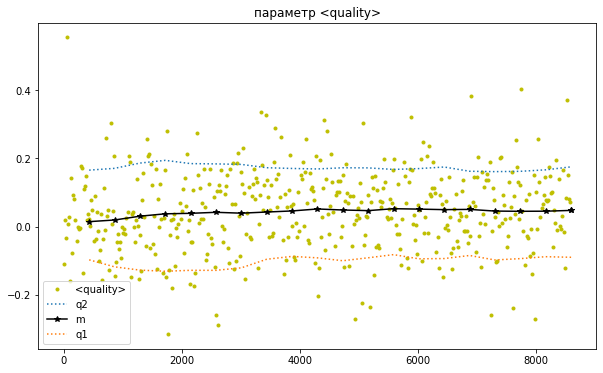

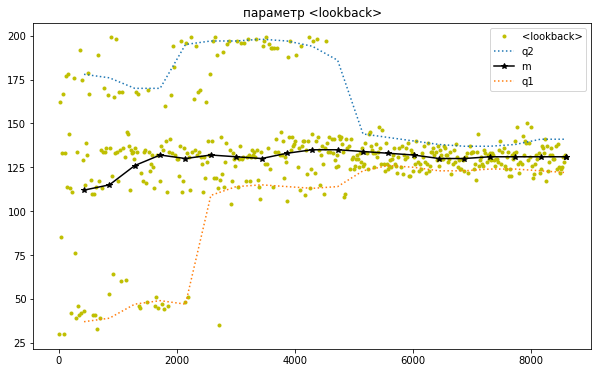

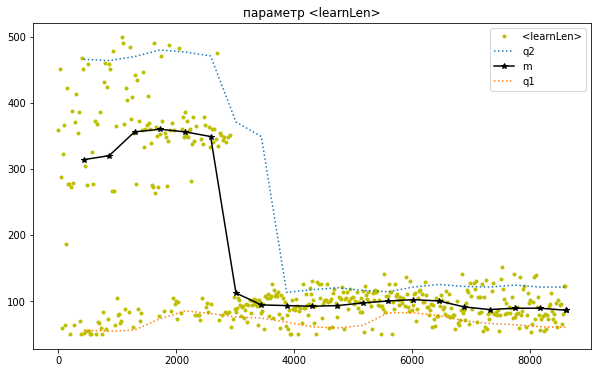

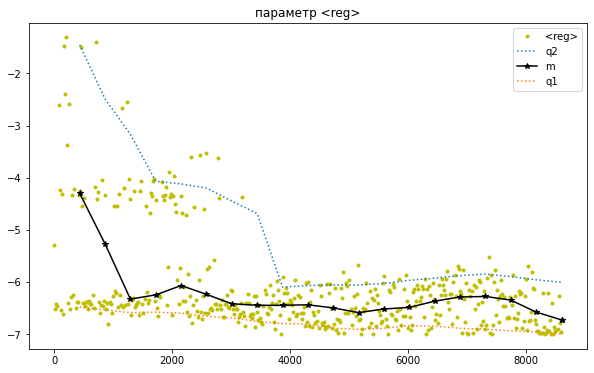

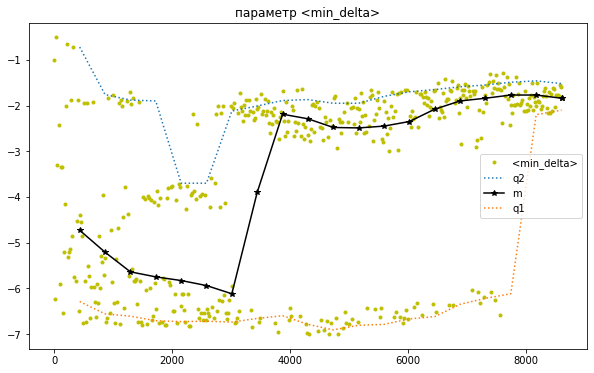

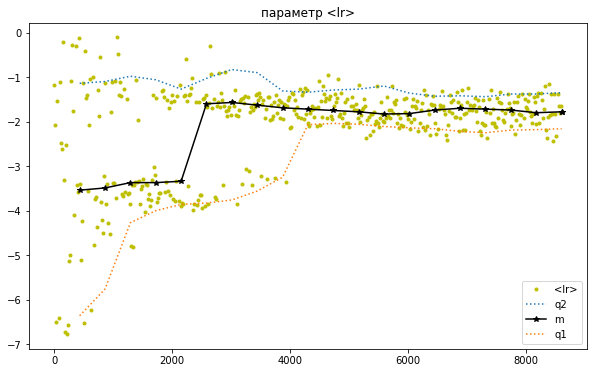

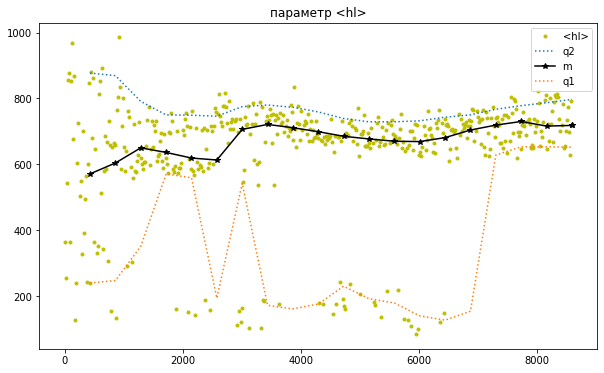

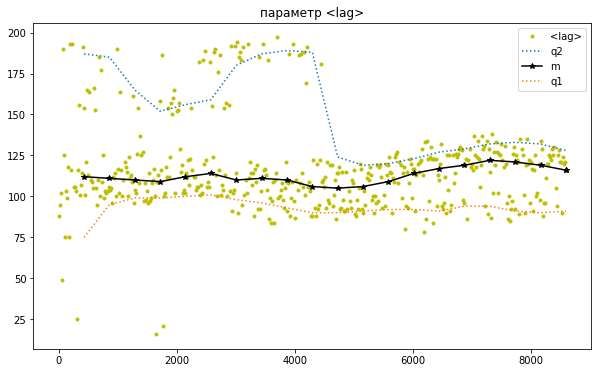

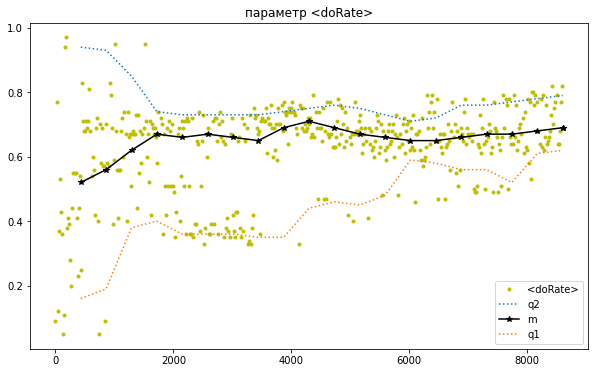

In [73]:
modelGA.plot_hist_new(('quality','lookback','learnLen','reg','min_delta','lr','hl','lag','doRate'))


## Параметры лучшей

In [67]:
best_par = modelGA.getBestParams()
best_par

{'doRate': 0.7100000000000001,
 'hl': 720,
 'lag': 111,
 'learnLen': 91,
 'lookback': 130,
 'lr': -1.7400000000001121,
 'min_delta': -1.8200000000001104,
 'reg': -6.660000000000007}

# Прогон лучшей

In [68]:
lookback_best = best_par['lookback']
lag_best = best_par['lag']
learnLen_best = best_par['learnLen']
reg_best = best_par['reg']
min_delta_best = best_par['min_delta']
lr_best = best_par['lr']
hl_best = best_par['hl']
doRate_best = best_par['doRate']

s_best = bt.Strategy('лучший', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best*2+learnLen_best+lookback_best+1),
                                bt.algos.SelectAll(),
                                WeighPredTF(lookback=lookback_best,
                                            learnLen=learnLen_best,
                                            reg=reg_best,
                                            min_delta=min_delta_best,
                                            lr=lr_best,
                                            hl=hl_best,
                                            lag=lag_best,
                                            doRate=doRate_best),
                                bt.algos.Rebalance()])
test_best = bt.Backtest(s_best, data)

s0 = bt.Strategy('равновесный', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best+learnLen_best+lookback_best+1),
                                 bt.algos.SelectAll(),
                                 bt.algos.WeighEqually(),
                                 bt.algos.Rebalance()])
test0 = bt.Backtest(s0, data)

res_best = bt.run(test_best,test0)

лучший
0% [############################# ] 100% | ETA: 00:00:00равновесный
0% [############################# ] 100% | ETA: 00:00:00

## График баланса

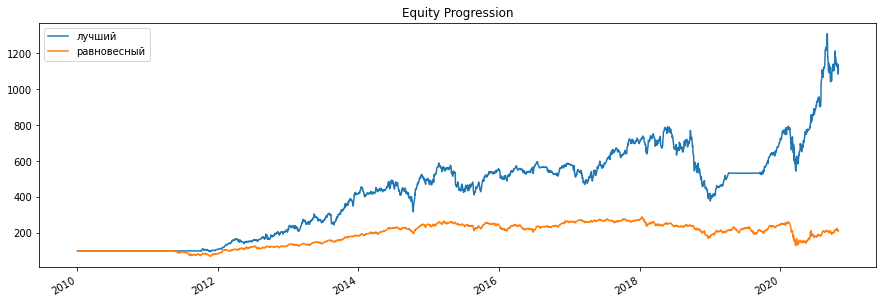

In [69]:
res_best.plot()

## график распределения долей

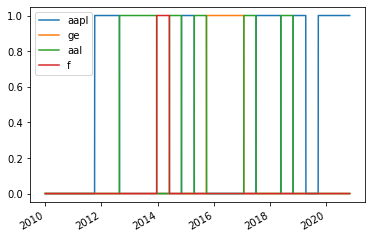

In [70]:
res_best.get_security_weights().plot()

## график распределения свободной доли

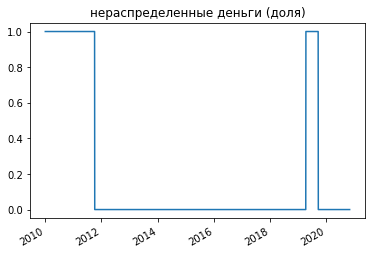

In [71]:
w = res_best.get_weights(0)
w['деньги'] = 1-w.values[:,1:].sum(axis=1)
w['деньги'].plot()
plt.title('нераспределенные деньги (доля)')
del(w)

## итог

In [72]:
res_best.display()

Stat                 лучший      равновесный
-------------------  ----------  -------------
Start                2010-01-03  2010-01-03
End                  2020-10-29  2020-10-29
Risk-free rate       0.00%       0.00%

Total Return         1017.61%    112.47%
Daily Sharpe         0.91        0.41
Daily Sortino        1.48        0.65
CAGR                 24.99%      7.21%
Max Drawdown         -52.20%     -55.69%
Calmar Ratio         0.48        0.13

MTD                  -0.94%      6.51%
3m                   20.92%      14.61%
6m                   60.20%      34.36%
YTD                  57.35%      -13.02%
1Y                   90.49%      -3.38%
3Y (ann.)            17.78%      -7.21%
5Y (ann.)            16.62%      -3.59%
10Y (ann.)           27.30%      7.83%
Since Incep. (ann.)  24.99%      7.21%

Daily Sharpe         0.91        0.41
Daily Sortino        1.48        0.65
Daily Mean (ann.)    26.54%      9.91%
Daily Vol (ann.)     29.04%      24.27%
Daily Skew           -0.03    

Енин А.В.

Оренбург